# Plotting

Xvec enables plotting of the data in the vector data cube on the geometry, both coordinate and variable. The functionality is not baked into the Xarray's methods but exposed on the `.xvec` accessor as `.xvec.plot`. While we try to keep its API consistent with `Dataset.plot`, there are some differences.

In [1]:
import geodatasets
import geopandas as gpd
import xarray as xr

import xvec

## Plotting using coordinate geometries

When you have coordinate geometry, you can use it to visualise the data from the DataArrray. Let's create an example as an outcome of zonal statistics of ERA-Interim data linked to US counties.

In [2]:
ds = xr.tutorial.open_dataset("eraint_uvz")
counties = gpd.read_file(geodatasets.get_path("geoda natregimes")).to_crs(4326)

aggregated = ds.xvec.zonal_stats(
    counties.geometry,
    x_coords="longitude",
    y_coords="latitude",
    method="iterate",  # polygons are small compared to pixels
    all_touched=True,
)
aggregated

/Users/martin/dev/xvec/.pixi/envs/default/lib/python3.13/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'z' has non-conforming '_FillValue' np.float64(nan) defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)
/Users/martin/dev/xvec/.pixi/envs/default/lib/python3.13/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'u' has non-conforming '_FillValue' np.float64(nan) defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)
/Users/martin/dev/xvec/.pixi/envs/default/lib/python3.13/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'v' has non-conforming '_FillValue' np.float64(nan) defined, dropping '_FillValue' entirely.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 469kB
Dimensions:   (geometry: 3085, month: 2, level: 3)
Coordinates:
  * level     (level) int32 12B 200 500 850
  * month     (month) int32 8B 1 7
  * geometry  (geometry) object 25kB POLYGON ((-95.34258270263672 48.54670333...
Data variables:
    z         (geometry, month, level) float64 148kB 1.119e+05 ... 1.477e+04
    u         (geometry, month, level) float64 148kB 22.81 15.31 ... 12.0 0.9052
    v         (geometry, month, level) float64 148kB -10.04 -8.724 ... 0.4852
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)
Attributes:
    Conventions:  CF-1.0
    Info:         Monthly ERA-Interim data. Downloaded and edited by fabien.m...

The resulting Dataset is 3-dimensional but each suplot can only contain a single array of values. Subset the data to get a 2-dimesional cube, allowing you to use one dimension (geometry) as a container to show the other data along the other dimension.

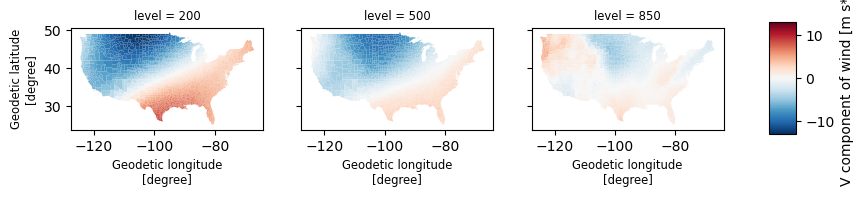

In [3]:
f, ax = aggregated.v.sel(month=1).xvec.plot(col="level")

The plots can be customized in the similar way xarray plotting normally supports. On top of that, remaining keywords are passed to `geopandas.GeoDataFrame.plot` the is used under the hood.

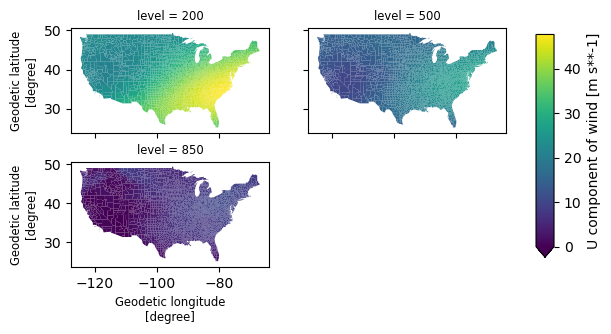

In [4]:
f, ax = aggregated.u.sel(month=1).xvec.plot(
    col="level", col_wrap=2, vmin=0
)

However, you can also use 3-dimensions and facet subplots along two of the dimensions.

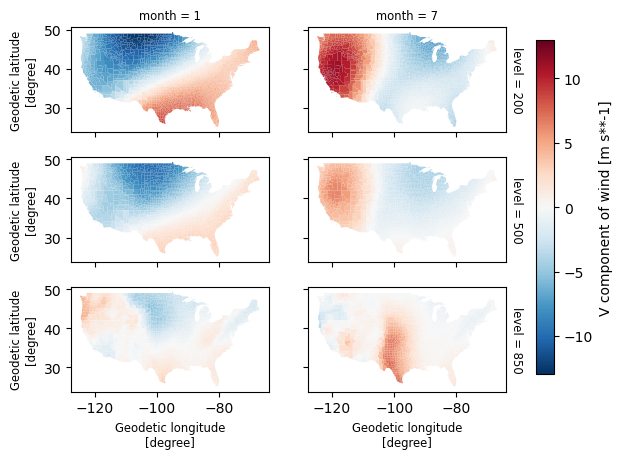

In [5]:
f, ax = aggregated.v.xvec.plot(col="month", row="level")

## Plotting using variable geometry

In the case of a data cube with variable geometry, you may need to plot that, optionally with some data linked to it. Let's generate a cube based on Svalbard glaciers.

In [6]:
glaciers_df = gpd.read_file("https://github.com/loreabad6/post/raw/refs/heads/main/inst/extdata/svalbard.gpkg")
glaciers = (
    glaciers_df.set_index(["name", "year"])
    .to_xarray()
    .proj.assign_crs(spatial_ref=glaciers_df.crs)  # use xproj to store the CRS information
)
glaciers

<xarray.Dataset> Size: 432B
Dimensions:      (name: 5, year: 3)
Coordinates:
  * name         (name) object 40B 'Austre Brøggerbreen' ... 'Steenbreen'
  * year         (year) float64 24B 1.936e+03 1.99e+03 2.007e+03
  * spatial_ref  int64 8B 0
Data variables:
    length       (name, year) float64 120B 5.808e+03 5.265e+03 ... 1.819e+03
    fwidth       (name, year) float64 120B 1.254e+03 470.1 888.4 ... 279.4 202.6
    geometry     (name, year) object 120B POLYGON ((432375.11039999966 876165...
Indexes:
    spatial_ref  CRSIndex (crs=EPSG:32633)

Selecting a data array with geometry, you can plot their versions along the selected dimension.

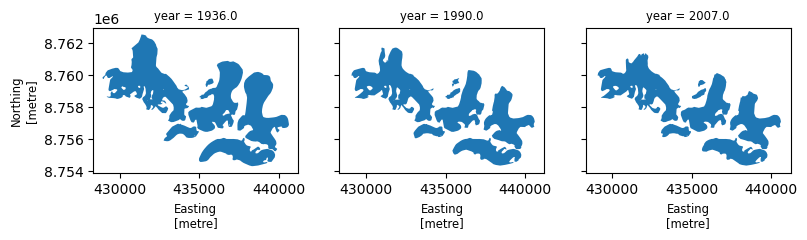

In [7]:
f, ax = glaciers.geometry.xvec.plot(col="year")

The faceting over two dimensions works here as well.

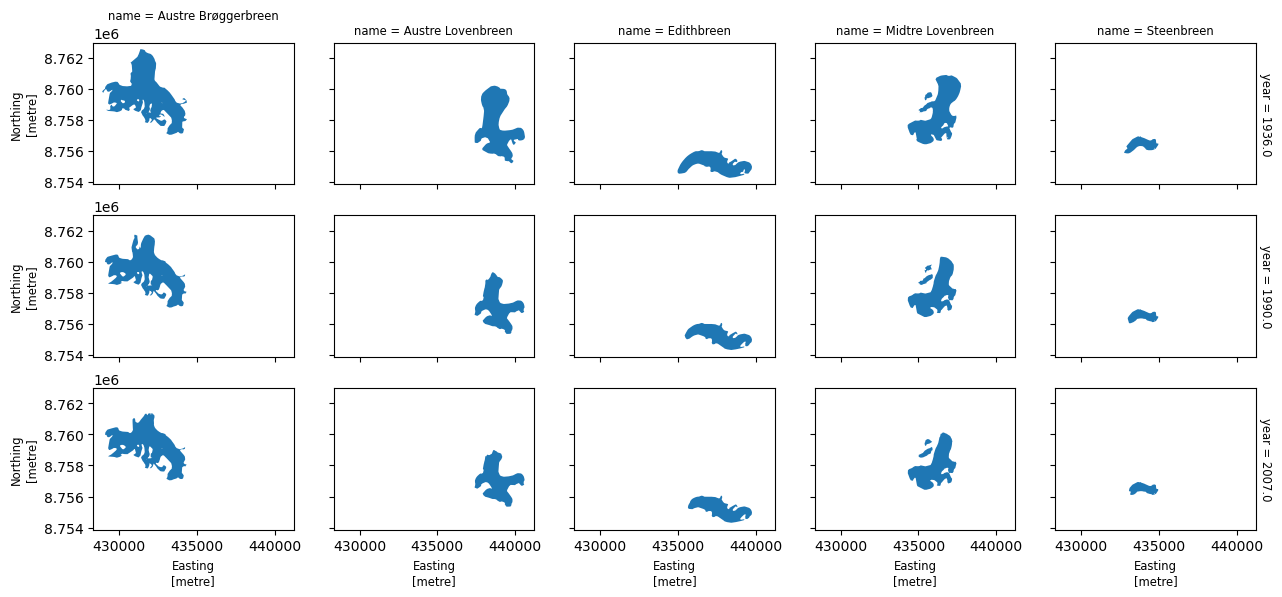

In [8]:
f, ax = glaciers.geometry.xvec.plot(col="name", row='year')

Alternatively, when dealing directly with the Dataset, you can get the same plot by specifiying which data variable contains geometry to be plotted.

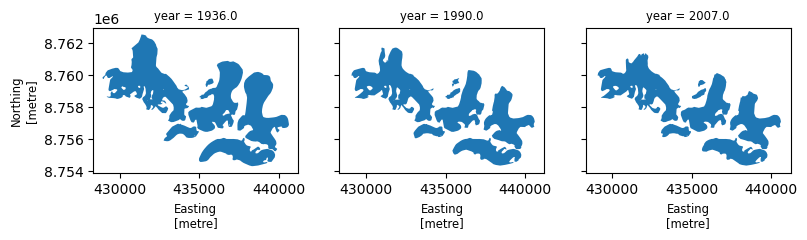

In [9]:
f, ax = glaciers.xvec.plot(col="year", geometry="geometry")

Another data variable can be plotted on the geometry by specifying `hue` keyword.

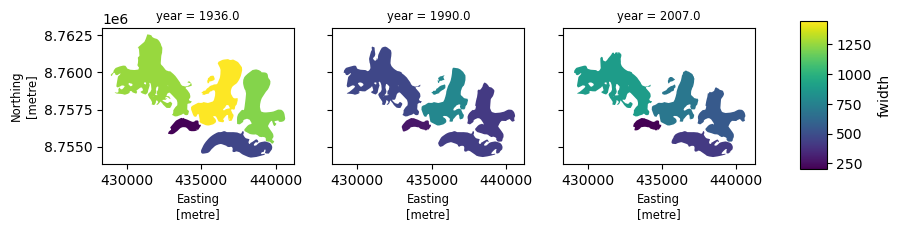

In [10]:
f, ax = glaciers.xvec.plot(col="year", geometry="geometry", hue="fwidth")

Or with categorical data.

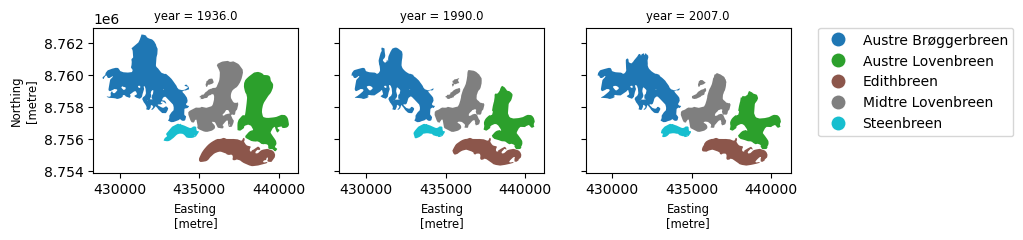

In [11]:
f, ax = glaciers.xvec.plot(col="year", geometry="geometry", hue="name")

## Switching between geometry representations

You may have a cube containing both variable and coordinate geometry. Plotting allows you to specify which should be used. Let's add summary geometry for our glaciers.

In [12]:
glaciers = glaciers.xvec.summarize_geometry(
    dim="name", geom_array="geometry", aggfunc="concave_hull", ratio=0.25
)
glaciers

<xarray.Dataset> Size: 472B
Dimensions:           (name: 5, year: 3)
Coordinates:
  * name              (name) object 40B 'Austre Brøggerbreen' ... 'Steenbreen'
  * year              (year) float64 24B 1.936e+03 1.99e+03 2.007e+03
  * spatial_ref       int64 8B 0
  * summary_geometry  (name) object 40B POLYGON ((431324.8682000004 8762430.3...
Data variables:
    length            (name, year) float64 120B 5.808e+03 ... 1.819e+03
    fwidth            (name, year) float64 120B 1.254e+03 470.1 ... 279.4 202.6
    geometry          (name, year) object 120B POLYGON ((432375.11039999966 8...
Indexes:
    spatial_ref       CRSIndex (crs=EPSG:32633)
    summary_geometry  GeometryIndex (crs=EPSG:32633)

You can quickly check how it looks by specifying it in the `geometry` keyword. If the variable has only one dimension, it can be directly plotted.

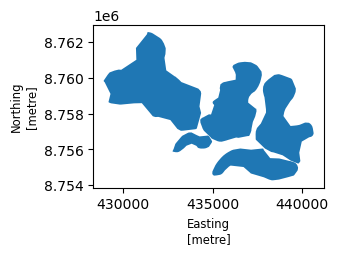

In [13]:
f, ax = glaciers.xvec.plot(geometry="summary_geometry")

The rest works in the same way as above. The subplot with values can be projected either on the original geometry or on the summary.

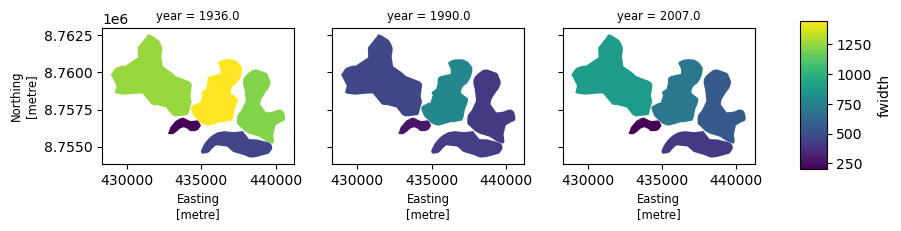

In [14]:
f, axs = glaciers.xvec.plot(
    col="year", geometry="summary_geometry", hue="fwidth"
)